In [1]:
from PIL import Image
import numpy as np
import tensorflow as tf
from keras import backend as K
from albumentations import Transpose,RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip, ElasticTransform

from skimage.io import imshow
%matplotlib inline
from matplotlib import pyplot as plt

%load_ext tensorboard
import datetime

import cv2

In [2]:
def read_tiff(path):
    """
    path - Path to the multipage-tiff file
    """
    img = Image.open(path)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        images.append(np.array(img))
    return np.array(images)

In [3]:
X_train = read_tiff('train-volume.tif')
Y_train = read_tiff('train-labels.tif')\
    
print("The shape of train set is {s1}.\nThe shape of train labels is {s2}.".format(s1=X_train.shape,s2=Y_train.shape))

The shape of train set is (30, 512, 512).
The shape of train labels is (30, 512, 512).


At Index : 24


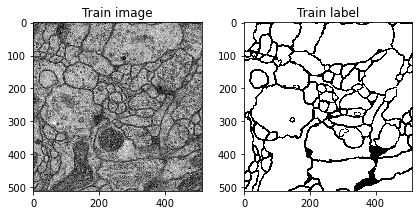

In [4]:
rand_num = np.random.randint(0,29)
print('At Index : {index}'.format(index = rand_num))
plt.subplot(121), imshow(X_train[rand_num])
plt.title('Train image') 

plt.subplot(122), imshow(Y_train[rand_num])
plt.title('Train label') 

plt.show()

In [5]:
finalaugimg = X_train
finalaugmask = Y_train

In [6]:
rr90imgs = []
rr90masks = []

for x,y in zip(X_train,Y_train):
    aug=RandomRotate90(p=1.0)
    augmented = aug(image=x,mask=y)
    rr90imgs.append(augmented['image'])
    rr90masks.append(augmented['mask'])

finalaugimg = np.concatenate([finalaugimg,rr90imgs])
finalaugmask = np.concatenate([finalaugmask,rr90masks])


In [7]:
gdimgs = []
gdmasks = []

for x,y in zip(X_train,Y_train):
    aug=GridDistortion(p=1.0)
    augmented = aug(image=x,mask=y)
    gdimgs.append(augmented['image'])
    gdmasks.append(augmented['mask'])

finalaugimg = np.concatenate([finalaugimg,gdimgs])
finalaugmask = np.concatenate([finalaugmask,gdmasks])

In [8]:
hfimgs = []
hfmasks = []

for x,y in zip(X_train,Y_train):
    aug=HorizontalFlip(p=1.0)
    augmented = aug(image=x,mask=y)
    hfimgs.append(augmented['image'])
    hfmasks.append(augmented['mask'])

finalaugimg = np.concatenate([finalaugimg,hfimgs])
finalaugmask = np.concatenate([finalaugmask,hfmasks])

In [9]:
vfimgs = []
vfmasks = []

for x,y in zip(X_train,Y_train):
    aug=VerticalFlip(p=1.0)
    augmented = aug(image=x,mask=y)
    vfimgs.append(augmented['image'])
    vfmasks.append(augmented['mask'])

finalaugimg = np.concatenate([finalaugimg,vfimgs])
finalaugmask = np.concatenate([finalaugmask,vfmasks])

In [10]:
timgs = []
tmasks = []

for x,y in zip(X_train,Y_train):
    aug=Transpose(p=1.0)
    augmented = aug(image=x,mask=y)
    timgs.append(augmented['image'])
    tmasks.append(augmented['mask'])
    
finalaugimg = np.concatenate([finalaugimg,timgs])
finalaugmask = np.concatenate([finalaugmask,tmasks])

In [11]:
etimgs = []
etmasks = []

for x,y in zip(X_train,Y_train):
    aug=ElasticTransform(sigma=10,interpolation=cv2.INTER_CUBIC)
    augmented = aug(image=x,mask=y)
    etimgs.append(augmented['image'])
    etmasks.append(augmented['mask'])

finalaugimg = np.concatenate([finalaugimg,etimgs])
finalaugmask = np.concatenate([finalaugmask,etmasks])

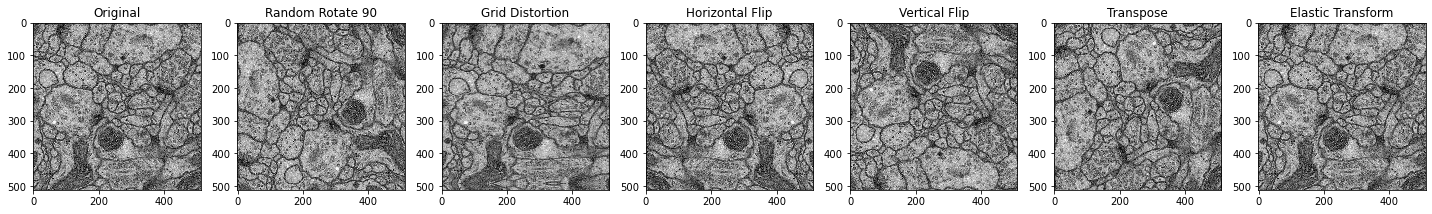

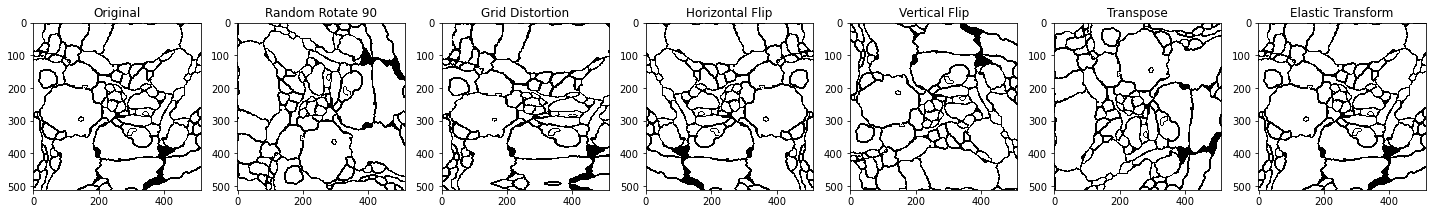

In [12]:
rand_nums = [rand_num,rand_num+30,rand_num+60,rand_num+90,rand_num+120,rand_num+150,rand_num+180]
plt.figure(figsize=(20,10))
plt.subplot(171), imshow(finalaugimg[rand_nums[0]])
plt.title('Original')
plt.subplot(172), imshow(finalaugimg[rand_nums[1]])
plt.title('Random Rotate 90')
plt.subplot(173), imshow(finalaugimg[rand_nums[2]])
plt.title('Grid Distortion')
plt.subplot(174), imshow(finalaugimg[rand_nums[3]])
plt.title('Horizontal Flip')
plt.subplot(175), imshow(finalaugimg[rand_nums[4]])
plt.title('Vertical Flip')
plt.subplot(176), imshow(finalaugimg[rand_nums[5]])
plt.title('Transpose')
plt.subplot(177), imshow(finalaugimg[rand_nums[6]])
plt.title('Elastic Transform')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(171), imshow(finalaugmask[rand_nums[0]])
plt.title('Original')
plt.subplot(172), imshow(finalaugmask[rand_nums[1]])
plt.title('Random Rotate 90')
plt.subplot(173), imshow(finalaugmask[rand_nums[2]])
plt.title('Grid Distortion')
plt.subplot(174), imshow(finalaugmask[rand_nums[3]])
plt.title('Horizontal Flip')
plt.subplot(175), imshow(finalaugmask[rand_nums[4]])
plt.title('Vertical Flip')
plt.subplot(176), imshow(finalaugmask[rand_nums[5]])
plt.title('Transpose')
plt.subplot(177), imshow(finalaugmask[rand_nums[6]])
plt.title('Elastic Transform')
plt.show()

In [13]:
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

In [15]:
#model

inputs = tf.keras.layers.Input((512,512,1))
float_inputs = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#contraction path
c1 = tf.keras.layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(float_inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(c1)

c2 = tf.keras.layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(512,3, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#expansion path 
u6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4],axis = 3)
c6 = tf.keras.layers.Conv2D(512,3, activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3],axis = 3)
c7 = tf.keras.layers.Conv2D(256,3, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(256,3, activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2],axis = 3)
c8 = tf.keras.layers.Conv2D(128,3, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(128,3, activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(64,3, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(64,3, activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=[focal_loss(alpha=.25, gamma=2)], metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 64) 0           conv2d[0][0]                     
_______________________________________________________________________________________

In [16]:
path_for_logs = '/logs'

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss',min_delta=0.0001),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1),
        tf.keras.callbacks.ModelCheckpoint('Pranjal-U-Net-Weights.h5', verbose=1, save_best_only=True),
        tf.keras.callbacks.TensorBoard(log_dir=path_for_logs)
        ]

results = model.fit(finalaugimg, finalaugmask/255, validation_split=0.1, batch_size=3, epochs=100, callbacks=callbacks)

Epoch 1/100
 1/63 [..............................] - ETA: 0s - loss: 0.0706 - accuracy: 0.4369WARNING:tensorflow:From C:\Users\pranj\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
 6/63 [=>............................] - ETA: 37:49 - loss: 0.0748 - accuracy: 0.5992

In [ ]:
%tensorboard --logdir logs

In [ ]:
X_test = read_tiff('test-volume.tif')

In [ ]:
preds_test = model.predict(X_test, verbose=1)

In [ ]:
new_pred = preds_test.reshape((30,512,512))


In [ ]:
imlist = []
for m in new_pred:
    imlist.append(Image.fromarray(m>0.5))

imlist[0].save("output-test-labels.tif", compression="tiff_deflate", save_all=True,
               append_images=imlist[1:])

In [ ]:
Y_test = new_pred > 0.5
results = []
for y,y_hat in zip(X_test,Y_test):
    results.append(y)
    results.append(y_hat)

In [ ]:
def show_images(images, nrows = 1):
    n_images = len(images)
    fig = plt.figure()
    for n, image in enumerate(images):
        a = fig.add_subplot(nrows, np.ceil(n_images/float(nrows)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        plt.axis('off')
    fig.set_size_inches(20,10)
    plt.show()

show_images(results,nrows = 6)